Hi Dan, Simon, while you two are living it up in the city of apples I've prepared some notes to get you up to speed. This notebook is a general mish-mash of all Maelstrom related things I've worked on over the past few months.

Summary:
- Everything in Maelstrom works except for the lighttime tensor (a1d), since Hemcee can't accept tensors of variable length
- I don't like the idea of using Hemcee if Dan isn't going to support it anymore
- I looked into alternative samplers and like the internal TF sampler, and PyMC3

***

 -  [Maelstrom](#Maelstrom)

***

<a id='Maelstrom'></a>
# 1. Maelstrom

In [8]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt

/Users/danielhey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We'll load up my fav star, 9651065

In [3]:
kic_id = 9651065
times, mags = np.loadtxt(f"data/kic{kic_id}_lc.txt",usecols=(0,1)).T

<a id='Spline'></a>
## 1.1 Spline fits

First off, the spline fits are fine. To jog your memory, we use those to model a time delay without extracting the actual phases from the lightcurve

In [4]:
N = 1000
np.random.seed(42)
# If no frequencies are supplied, maelstrom will automatically find some
model = ms.InterpMaelstrom(times, mags, log_sigma2=0.0,
                        interp_x=np.linspace(times.min(), times.max(), N),
                        interp_y=1e-5*np.random.randn(N))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.090488
  Number of iterations: 14
  Number of functions evaluations: 22


I've found that BFGS seems to be a bit more efficient than the Adam gradient descent optimizer we used previously for spline fitting, and have made that the default:

In [5]:
model.optimize([model.interp_y, model.log_sigma2])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804144.141773
  Number of iterations: 76
  Number of functions evaluations: 92


In [6]:
np.random.seed(42)
adam_model = ms.InterpMaelstrom(times, mags, log_sigma2=0.0,
                        interp_x=np.linspace(times.min(), times.max(), N),
                        interp_y=1e-5*np.random.randn(N))

adam_model.adam_optimizer([model.interp_y, model.log_sigma2])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.090488
  Number of iterations: 14
  Number of functions evaluations: 22


100%|██████████| 1000/1000 [01:03<00:00, 15.69it/s, chi2=0]


Quite a bit longer hey? They both produce a pretty similar output:

Text(0, 0.5, '$\\tau (s)$')

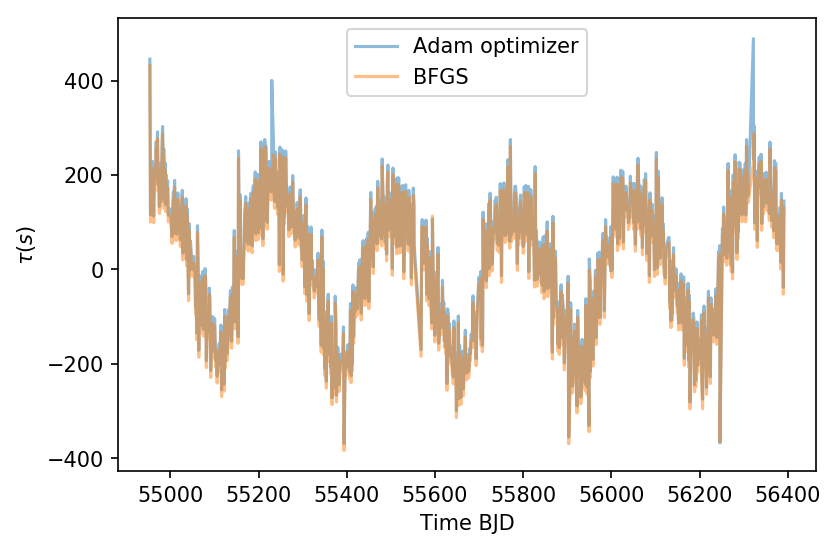

In [9]:
plt.plot(adam_model.time_data, adam_model.run(adam_model.tau)[:,0]*86400, alpha=0.5, label='Adam optimizer')
plt.plot(model.time_data, model.run(model.tau)[:,0]*86400, alpha=0.5, label='BFGS')

plt.legend()
plt.xlabel('Time BJD')
plt.ylabel(r'$\tau (s)$')

<a id='Sampling'></a>
## 1.2. Sampling

Here's where things go bad. Let's pass our model over to the Maelstrom class first

In [10]:
model = model.to_maelstrom()

and load up previously known values

In [11]:
# Previously known values
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
orb_params = orbits[orbits.Name == f"kic{kic_id}"].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"] 
tp = orb_params["t_p"]
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1#/86400.0

model.init_from_orbit(period=porb, lighttime=a1d, tref=tp, eccen=e, varpi=varpi)

The scipy optimizer does a pretty decent job at getting the right values. Well, I hope it would since we already start off with the correct ones

In [12]:
model.params = [
    model.period,
    model.eccen_param,
    model.tref,
    model.varpi,
    model.log_sigma2,
    model.lighttime
]

model.optimize()
model.run(model.params)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -803328.719542
  Number of iterations: 27
  Number of functions evaluations: 37


[272.10115163231455,
 -0.22405805088556732,
 55128.33955865588,
 2.1610720729434596,
 -13.546532876070819,
 array([184.46680872, 184.57373037, 184.61261343, 184.57321237,
        184.55659977, 184.55345611, 184.54640152, 184.55606587,
        184.55670417])]

Now we sample using _Hemcee_. The warmup method is defined (clunkily, sorry Dan) to replace tensor values at the end of the run, like scipy optimizer. I'm short on time so I won't run it for very long - especially since we're cheating and initialising the values at the known start. I'm not really sure about the internal workings of Hemcee, but it seems to assign a uniform step size for each parameter. If we do go the path of Hemcee, we'll need to normalise the values or something. Note how I remove the lighttime from the param list. I'll get to that in a sec

In [13]:
model.params = model.params[:-1]
model.run_warmup(samples=100)

initial warm up: step_size: 4.4e-02; mean(accept_stat): 0.415: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]
warm up 1/2: step_size: 6.7e-03; mean(accept_stat): 0.498: 100%|██████████| 25/25 [00:56<00:00,  2.25s/it]
warm up 2/2: step_size: 6.8e-03; mean(accept_stat): 0.458: 100%|██████████| 45/45 [01:38<00:00,  2.18s/it]
final warm up: step_size: 1.1e-02; mean(accept_stat): 0.302: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


In [14]:
model.run(model.params)

[271.8852877469189,
 -0.378485032072924,
 55128.97468673929,
 2.1632266707468437,
 -13.541126331925216]

I know these are tiny samples - I don't really have the time to let it run fully. It's just so you can both see how it's accessed

In [15]:
model.run_mcmc(samples=10)

step_size: 8.4e-03; mean(accept_stat): 0.706: 100%|██████████| 10/10 [00:37<00:00,  3.70s/it]


Maelstrom runs a lot faster in Spyder/Python scripts than it does in Jupyter notebooks for some reason.. I've seen it get up to 2 it/s

The Big Problem (tm) happens when you try to run Hemcee on an unusually shaped tensor, like say, the lighttime. Since there is a single lighttime for each frequency in the model, Hemcee is not happy. Ideally, we'd optimize the model first and then use the sampler on singly defined lighttimes, but Scipy.Optimizer gives pretty bad results when initialized away from the true value

In [16]:
model.params = [model.lighttime]
model.run_warmup(1000)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 3 into shape (9,)

I've tried all sorts of things to get this working from Maelstrom, but I'm just not good enough at TensorFlow to figure it out. You'll probably see the remnants of my attempts lying around the source code.

## PB2

Another issue is with PB2 systems. Although the lighttime tensor works fine with PB2/PB1/SB1 systems, it fails on SB2 systems. This is because both radial velocity `vrad` attribs share the same `lighttime` tensor. So when scipy, or anything else tries to optimize, it picks lighttime values that are almost exactly halfway between `a1` and `a2`. This is probably because i've screwed up the parametrization somewhere.

In [17]:
kic_id = 5709664 # PB2 system

# Load in the lightcurve and frequencies
times, mags = np.loadtxt(f"data/kic{kic_id}_lc.txt",usecols=(0,1)).T
nu_arr = np.loadtxt(f"data/kic{kic_id}_metadata.csv", delimiter=",", skiprows=1)[::6]

# Get the RV data
rvs = []
for i in 'ab':
    rvs.append(ms.maelstrom.RadialVelocity(*np.loadtxt(f"data/kic{kic_id}"+i+"_JDrv.txt", delimiter=",", usecols=(0,1,2)).T, meta=i))

# Previously known values
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
orb_params = orbits[orbits.Name == f"kic{kic_id}"].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"] 
tp = orb_params["t_p"]
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0

Let's optimize both sets of RV data in separate models to find what the lighttime should be

In [18]:
# Check both sets of RV data separately:
for rv in rvs:
    model = ms.Maelstrom(times, mags, nu=nu_arr,rvs=[rv])

    # Set lighttime to 0 so no preference, everything else is fixed to their known values
    model.init_from_orbit(period=porb, lighttime=0, tref=tp, eccen=e, varpi=varpi)

    # Optimize:
    model.optimize([model.lighttime])

    # Output
    print(model.rvs[0].meta, model.pin_lighttime_values()[1])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 28066.501510
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 28066.501510
  Number of iterations: 2
  Number of functions evaluations: 5


a [66.02411618]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 30047.114901
  Number of iterations: 2
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 30047.114901
  Number of iterations: 2
  Number of functions evaluations: 6


b [-142.83039249]


Now we'll use both at once in a single model

In [19]:
model = ms.Maelstrom(times, mags, nu=nu_arr, rvs=rvs)
model.init_from_orbit(period=porb, lighttime=0, tref=tp, eccen=e, varpi=varpi)

# Optimize
model.optimize([model.lighttime])

model.pin_lighttime_values()[1]

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 92424.232337
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 92424.232337
  Number of iterations: 2
  Number of functions evaluations: 5


array([-38.81411695])

In [20]:
(66.02411618 + -142.83039249) / 2

-38.40313815500001

See how the optimizer takes the exact average value between both light times? this is a parametrization problem 

<a id='bound'></a>
## 1.3. Bound parameters

Bounding parameters also works nicely. I haven't included this in Maelstrom yet but here's an example

In [24]:
import hemcee
from hemcee.sampler import TFModel
from maelstrom.kepler import kepler
import tensorflow as tf

In [22]:
kicid=9651065 # PB1/SB1

times, dmag = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid
dmmags = dmag * 1000. 
metadata = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)
nu_arr = metadata[::6]

# Read in data
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
orb_params = orbits[orbits.Name == f"kic{kicid}"].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"] 
tp = orb_params["t_p"] - time_mid 
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1#/86400.0

In [25]:
# DFM black magic
class BoundParam(object):
    def __init__(self, name, value, min_value, max_value, dtype=tf.float64):
        self.name = name
        self.value = value
        self.min_value = min_value
        self.max_value = max_value
        
        # Bound
        self.param = tf.Variable(self.get_bounded_for_value(self.value, self.min_value, self.max_value), dtype=dtype, name=name + "_param")
        self.var = self.min_value + (self.max_value - self.min_value) / (1.0 + tf.exp(-self.param))
        
        self.log_jacobian = tf.log(self.var - self.min_value) + tf.log(self.max_value - self.var) - np.log(self.max_value - self.min_value)
        # Add this to the log prior
        self.log_prior = tf.reduce_sum(self.log_jacobian)
    def get_bounded_for_value(self, value, min_val, max_val):
        # Check if correct bounds
        if np.any(value <= min_val) or np.any(value >= max_val):
            raise ValueError("Value must be within the given bounds")
        return np.log(value-min_val)-np.log(max_val-value)
    
    def get_value_for_bounded(self,param):
        return self.min_value + (self.max_value - self.min_value) / (1.0 + np.exp(-param))

I put them into a class so I could keep track of them all. The .var attribute is used for modelling and the .param is used for fitting. TensorFlow is really nice like that..

In [26]:
sess = tf.InteractiveSession()
T = tf.float64

# Unbound tensors
nu_tensor = tf.Variable(nu_arr, dtype=T)

# Bound tensors
porb_tensor = BoundParam('Porb', porb, 1, 500)  # Orbital period
varpi_tensor = BoundParam('Varpi', varpi, 0, 2*np.pi)   # Angle of the ascending node
tp_tensor = BoundParam('t_p', tp, -1000, 0) # Time of periastron
e_tensor = BoundParam('e', e, 1e-10, 0.99) # Eccentricity
log_sigma2_tensor = BoundParam('log_sigma2', 0., -5, 5) # Known value
a1d_tensor = BoundParam('a_1d', a1d, 0., 300.) # Projected semimajor axis

You can see below that Hemcee is fine sampling this since I've only defined a single lighttime value for all frequencies

In [27]:
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

# Solve Kepler's equation
mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor.var) / porb_tensor.var
ecc_anom = kepler(mean_anom, e_tensor.var)
true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor.var)*tf.tan(0.5*ecc_anom),tf.sqrt(1.0-e_tensor.var) + tf.zeros_like(times_tensor))

# Here we define how the time delay will be calculated:
tau_tensor = -(a1d_tensor.var / 86400) * (1.0 - tf.square(e_tensor.var)) * tf.sin(true_anom + varpi_tensor.var) / (1.0 + e_tensor.var*tf.cos(true_anom))

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor - tau_tensor)[:, None]
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor)) # Removes dimensions of size 1 from the shape of a tensor.
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor.var)
chi2_tensor += len(times) * (log_sigma2_tensor.var)

In [28]:
init = tf.global_variables_initializer()
sess.run(init)

In [29]:
# Feed dict
feed_dict = {
    times_tensor: times,
    dmmags_tensor: dmmags
}

# Variables to be fit
var = [
    porb_tensor,
    varpi_tensor,
    tp_tensor,
    a1d_tensor,
    e_tensor,
    log_sigma2_tensor,
]

# We need the params of the vars to fit
var_list = [tensors.param for tensors in var]

In [30]:
log_prior = tf.constant(0.0, dtype=tf.float64)
# Add the jacobian to the prior
for tensor in var:
    if tensor.log_prior is not None:
        log_prior += tensor.log_prior

# Define log probability
log_prob = - 0.5 * chi2_tensor + log_prior

# Bind to tensorflow model
model = TFModel(log_prob, var_list=var_list, feed_dict=feed_dict)
model.setup()
coords = model.current_vector()

metric = hemcee.metric.DenseMetric(np.eye(len(coords)))
step = hemcee.step_size.VariableStepSize()
sampler = hemcee.NoUTurnSampler(model.value, model.gradient, step_size=step, metric=metric)

In [29]:
# Burn-in
results = sampler.run_warmup(coords, 50, tune_metric=True)

initial warm up: step_size: 9.6e-04; mean(accept_stat): 0.167:  60%|██████    | 6/10 [00:01<00:01,  3.28it/s]/Users/danielhey/anaconda3/lib/python3.6/site-packages/hemcee-0.0.0-py3.6.egg/hemcee/nuts.py:46: RuntimeWarning: overflow encountered in exp
  sum_metro_prob += min(np.exp(H0 - h), 1.0)
initial warm up: step_size: 1.6e-03; mean(accept_stat): 0.330: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]
warm up 1/1: step_size: 1.1e-03; mean(accept_stat): 0.478: 100%|██████████| 35/35 [01:13<00:00,  2.10s/it]
final warm up: step_size: 1.3e-01; mean(accept_stat): 0.403: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


In [ ]:
coords_chain, logprob_chain = sampler.run_mcmc(
            results[0], 
            5000, 
            initial_log_prob=results[1],
            )

I don't have the time to run this manually so let's just pretend i did. Here's one I prepared earlier. Red are Maelstrom solutions and blue are previous solutions from orb_params. Strangely enough this only took an hour to compute for 5000 steps with 2000 step burn in.

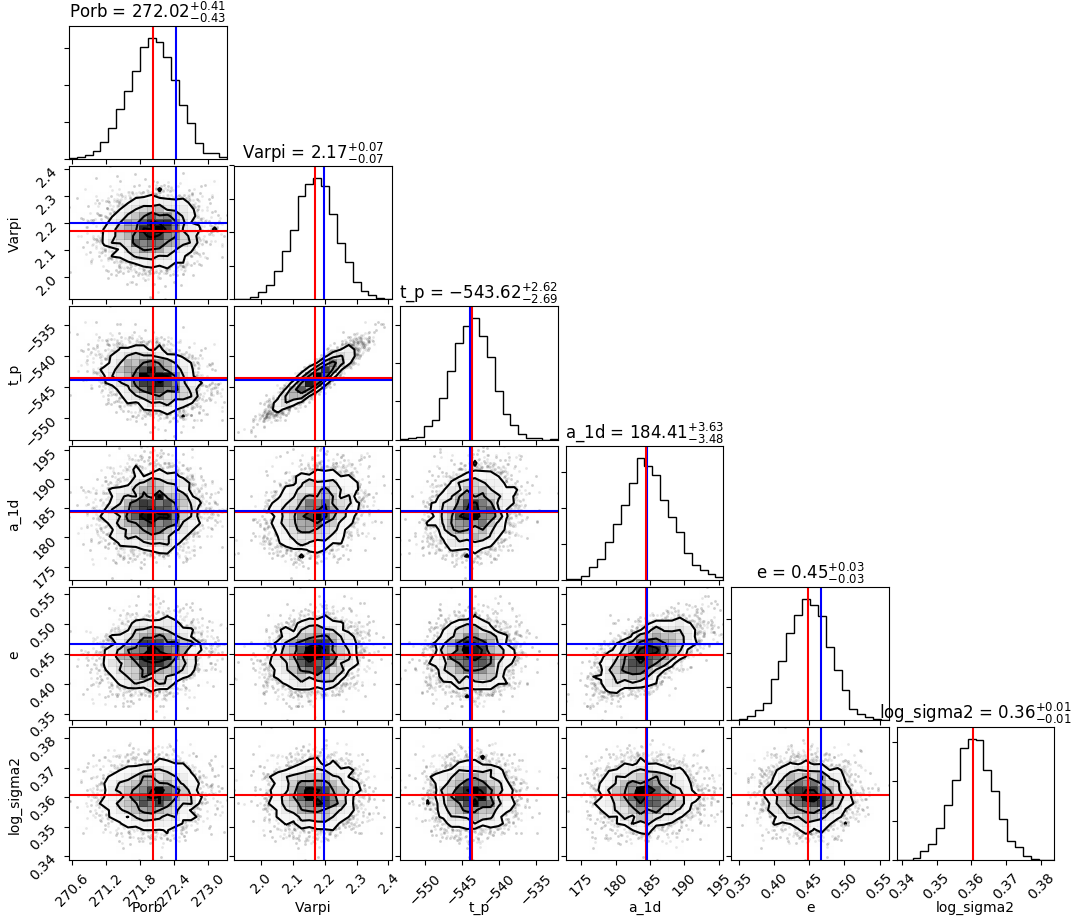

That a1d should say a1s

I've included a rather messy (sorry) Python script for using Maelstrom with SB2 systems as well. It's not automated, so you'd need to adjust things manually before running it on a system. The script is setup for KIC5709664 (sb2.py)

<a id='Alternatives'></a>
# 2. Alternatives

Now, I couldn't help but notice Dan said he doesn't have the time to maintain Hemcee anymore. That's fine, but I don't like the idea of building Maelstrom on top of a sampler which won't have any support going forward. I can take over maintenence, but I'm not really clever enough to improve it. 

Here are some alternatives I've looked at:

<a id='tf_prob'></a>
## 2.1. tensorflow_probability

TensorFlow is a modern package. It has a job, 2 kids, a wife. It doesn't have time to mess around with alternative samplers. That's why the TF team have been working on building a very neat little module to handle probabilistic models. Check it out:

In [31]:
tf.InteractiveSession.close(sess)

In [33]:
import tensorflow_probability as tfp

sess = tf.InteractiveSession()
T = tf.float32

kicid=9651065 # PB1/SB1

times, dmag = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid
dmmags = dmag * 1000. 
metadata = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)
nu_arr = metadata[::6]

# Read in data
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
orb_params = orbits[orbits.Name == f"kic{kicid}"].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"] 
tp = orb_params["t_p"] - time_mid 
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1#/86400.0


/Users/danielhey/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [34]:
nu_tensor = tf.Variable(nu_arr, dtype=T)

e_param = np.log(e) - np.log(1.0 - e)
porb_tensor = tf.Variable(porb, dtype=T)
tp_tensor = tf.Variable(porb, dtype=T)
e_param_tensor = tf.Variable(e_param, dtype=T)  # This forces the ecc to be between 0 and 1
e_tensor = 1.0 / (1.0 + tf.exp(-e_param_tensor))
varpi_tensor = tf.Variable(varpi, dtype=T)
log_sigma2_tensor = tf.Variable(0.0, dtype=T)
porb_tensor = tf.Variable(porb, dtype=T)
ad_tensor = tf.Variable(a1d, dtype=T)
    
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

Here's where we define the log prob

In [36]:
def target_log_prob(porb_tensor,
                    #varpi_tensor,tp_tensor,a1d_tensor, e_tensor,log_sigma2_tensor
                    ):
    
    # Solve Kepler's equation
    mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor
    ecc_anom = kepler(mean_anom, e_tensor)
    true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*ecc_anom),tf.sqrt(1.0-e_tensor) + tf.zeros_like(times_tensor))
    
    # Here we define how the time delay will be calculated:
    tau_tensor = -(ad_tensor / 86400) * (1.0 - tf.square(e_tensor)) * tf.sin(true_anom + varpi_tensor) / (1.0 + e_tensor*tf.cos(true_anom))
    
    # And the design matrix:
    arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor - tau_tensor)[:, None]
    D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)
    
    # Define the linear solve for W_hat:
    DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
    DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
    W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)
    
    # Finally, the model and the chi^2 objective:
    model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor)) # Removes dimensions of size 1 from the shape of a tensor.
    chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
    chi2_tensor += len(times) * (log_sigma2_tensor)
    
    return - 0.5 * chi2_tensor # + self.ln_prior

In [37]:
feed_dict = {
    times_tensor: times,
    dmmags_tensor: dmmags
}

# I'm cutting things out for speed
var = [
    porb_tensor,
]

In [38]:
# Define a variable step size
step_size = tf.get_variable(
    name='step_size',
    initializer=1.,
    use_resource=True,  # For TFE compatibility.
    trainable=False)

# Initialize the HMC transition kernel.
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy())

# Run the chain (with burn-in). Yes I know there are very little samples.. but there's no progress bar
samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=int(10),
    num_burnin_steps=int(10),
    current_state=var,
    kernel=hmc)

In [39]:
# Initialize all constructed variables.
init_op = tf.global_variables_initializer()

# Run the model
with tf.Session() as sess:
    init_op.run()
    samples_, kernel_results_ = sess.run([samples, kernel_results], feed_dict=feed_dict)

In [40]:
samples_[0].mean()

272.4251

While nice, it's a little experimental and is lacking support/docs. Although on the plus side it removes a huge dependency from Maelstrom

<a id='pymc3'></a>
# 2.2. PyMC3

Here's the big cheese itself - PyMC3. I'm a total sucker for simplicity because i'm useless at MCMC. It has insane support and features coming out the wazoo. Here's a very basic model below. The nicest thing is that it automatically supports tensors of variable length.

**N.B. You'll probably want to restart the kernel at this point if you're running the code. Something weird happens to PyMC when you run all the previous stuff first**

In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
kicid = 9651065
metadata = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)
nu_arr = metadata[::6]
times, mags = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T

# Subtract midpoint
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid

nu_arr = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)[::6]
nu_arr = nu_arr[:3]

mags *= 1000.

In [26]:
print(len(times))

64028


Suss out the lighttime down there

In [19]:
import theano.tensor as tt
import pymc3 as pm
import exoplanet as xo
from exoplanet.orbits import get_true_anomaly

nu_arr = np.array(nu_arr)

t = times
y = mags
print(np.var(y))

with pm.Model() as model:
    # Parameters
    period = pm.Normal("period", mu=272., sd=100)
    tref = pm.Normal("tref", mu=0.0, sd=100.0)
    varpi = xo.distributions.Angle("varpi")
#     varpi = pm.Uniform("varpi", lower=1e-2, upper=10)
    eccen = pm.Uniform("eccen", lower=1e-5, upper=1.0 - 1e-5)
    logs = pm.Normal('logs', mu=np.log(np.std(y)), sd=100)
    lighttime = pm.Normal('lighttime', mu=0.0, sd=100.0, shape=len(nu_arr))

#     tref = pm.Uniform("tref", lower=-50000, upper=50000)
#     varpi = pm.Uniform("varpi", lower=1e-2, upper=10)
#     eccen = pm.Uniform("eccen", lower=1e-11, upper=0.99)
#     #jitter = pm.Uniform('jitter', lower=0, upper=10)
#     lighttime = pm.Uniform('lighttime', lower=-5000, upper=5000, shape=(len(nu_arr)))
    
    # Mean anom
    M = 2.0 * np.pi * (t - tref) / period
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    
    psi = - (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))
    
    # tau in d
    tau = (lighttime)[None,:] * psi[:,None]
    tau /= 86400.
    
    # Sue me
    tau = pm.Deterministic('tau', tau)
    
    arg = 2. * np.pi * nu_arr[None, :] * (t[:,None] - tau)
    D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
#     DTD = tt.dot(D.T, D)
#     DTy = tt.dot(D.T, y[:, None])
#     W_hat = tt.slinalg.solve(DTD, DTy)
    W_hat = pm.Normal("W_hat", mu=0.0, sd=100.0, shape=2*len(nu_arr))
    
    model_tensor = tt.squeeze(tt.dot(D, W_hat[:, None]))
    
    # Sue me again
    model_tensor = pm.Deterministic('lc', model_tensor)
    
    # Condition on the observations
    pm.Normal("obs", mu=model_tensor, sd=tt.exp(logs), observed=y)

4.575709368621659


Let's also check what takes up the most time. I'm genuinely blown away by how fast the KeplerOp is in Exoplanet. It used to take up the majority of the computation time before the update

In [20]:
func = model.logp_dlogp_function(profile=True)
func.set_extra_values({})
x = np.random.randn(func.size)
%timeit func(x)

func.profile.summary()

31 ms ± 504 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Function profiling
  Message: /Users/dforeman/anaconda3/lib/python3.7/site-packages/pymc3/model.py:448
  Time in 81 calls to Function.__call__: 2.496497e+00s
  Time in Function.fn.__call__: 2.493261e+00s (99.870%)
  Time in thunks: 2.428430e+00s (97.273%)
  Total compile time: 1.576208e+00s
    Number of Apply nodes: 156
    Theano Optimizer time: 1.229494e+00s
       Theano validate time: 3.412986e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 9.624887e-02s
       Import time 0.000000e+00s
       Node make_thunk time 9.082913e-02s
           Node IncSubtensor{InplaceInc;int64:int64:}(IncSubtensor{InplaceInc;int64:int64:}.0, (d__logp/dW_hat), Constant{9}, Constant{15}) time 6.329060e-03s
           Node CGemv{no_inplace}(W_hat, TensorConstant{1.0}, InplaceDimShuffle{1,0}.0, InplaceDimShuffle{0}.0, TensorConstant{-0.0001}) time 6.228924e-03s
           Node Elemwise{Composite{((i0 * i1 * i2 * i3 * (((i4 * i5 * i6 * i7 * Composite{(i0 + (i1 * cos(i2)) + i3)}(i0

Now we can optimize it

In [21]:
import exoplanet as xo
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln)

success: False
initial logp: -139605.63834605576
final logp: -113490.80857886866
success: False
initial logp: -113490.80857886866
final logp: -113490.80857886866


In [22]:
map_soln

{'period': array(271.74831886),
 'tref': array(1.94964397),
 'varpi_angle__': array([-0.00965295,  0.01290079]),
 'eccen_interval__': array(-0.22263933),
 'logs': array(0.35244089),
 'lighttime': array([177.81775283, 189.77908457, 192.71423239]),
 'W_hat': array([ 1.63576246,  0.06829415, -0.54950538, -1.06896695, -0.86482665,
        -0.48043035]),
 'varpi': array(2.21317302),
 'eccen': array(0.44457006),
 'tau': array([[0.002709  , 0.00289123, 0.00293595],
        [0.00270906, 0.0028913 , 0.00293601],
        [0.00270912, 0.00289136, 0.00293608],
        ...,
        [0.00145206, 0.00154974, 0.00157371],
        [0.00145142, 0.00154906, 0.00157301],
        [0.00145078, 0.00154837, 0.00157232]]),
 'lc': array([-1.05742267, -0.80114711,  2.11979196, ...,  2.43588929,
        -3.18036305,  2.80741009])}

And plot the time delay for each frequency

Text(0, 0.5, 'Time delay (s)')

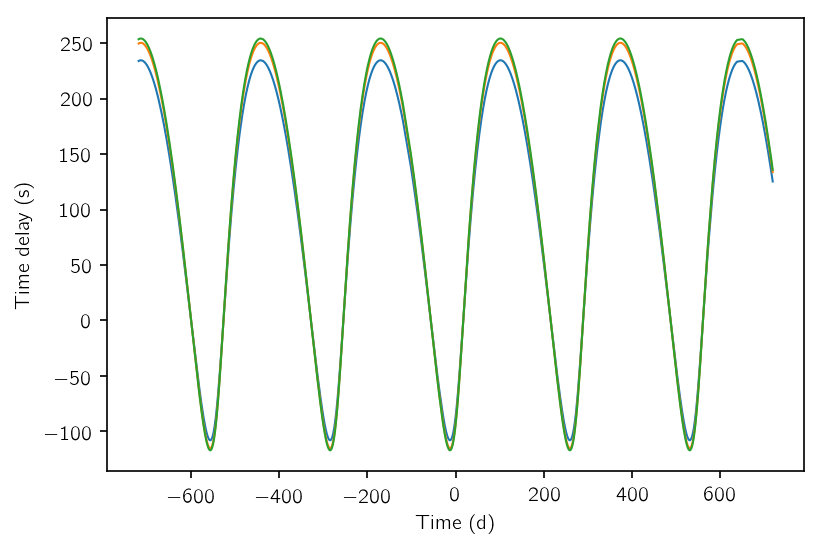

In [23]:
plt.plot(times, map_soln['tau']*86400-np.mean(map_soln['tau']), 
         lw=1)
plt.xlabel('Time (d)')
plt.ylabel('Time delay (s)')

We can also look at what the actual lightcurve model is

Text(0.5, 1.0, 'ehh')

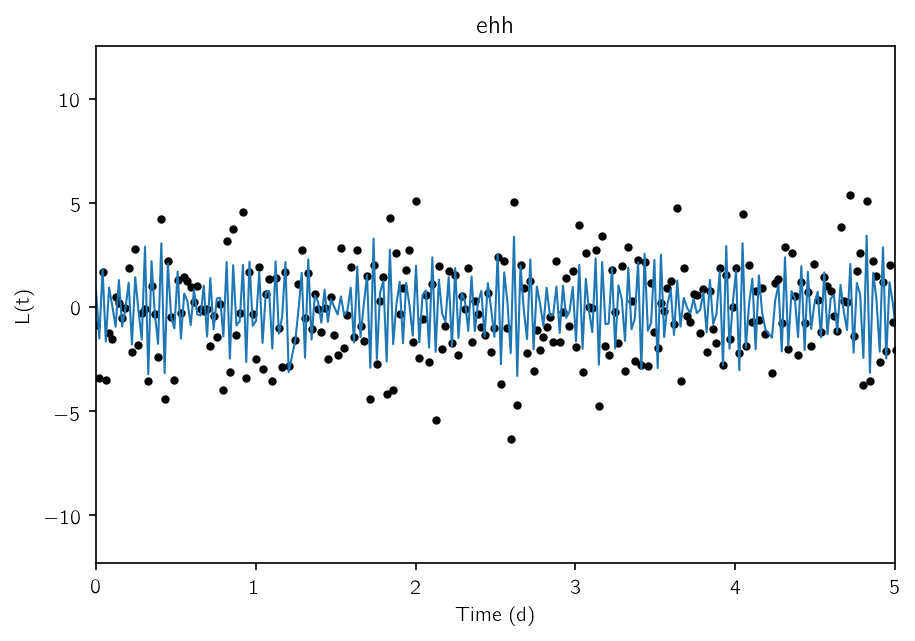

In [24]:
plt.plot(times, mags, ".k")
plt.plot(times, map_soln['lc'], color="C0", lw=1)

plt.tight_layout()
plt.xlim(0,5)
#plt.ylim(-1, 5)
plt.xlabel("Time (d)")
plt.ylabel("L(t)");
plt.title('ehh')

Quite frankly, the exoplanet optimizer / map_params does a fantastic job of getting pretty much the correct values straightaway. I've noticed that the orbital period seems to the be most volatile aspect of the model - which is why initialising it to a mostly correct value is important. For most cases, it'd be best to just take the amplitude spectrum of the time delay curve to initialise.

Anyway, we can sample now using the built-in sampler. And before DFM says "but Daniel! My wonderful exoplanet package has a built in sampler that tunes automatically for covariance!", let him know that I've tried it and haven't gotten it to work much better than the default sampler.

On my Mac (but not a Linux desktop), sampling multi core (chains>1, cores>1) does not work. Also I know initialising the sampler from a MAP is heresy, but here we are

In [25]:
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=3000, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 2 chains:   5%|▌         | 22/404 [01:31<26:22,  4.14s/draws]


ValueError: Not enough samples to build a trace.

In [11]:
with model:
    trace = pm.sample(draws=1000, 
                      tune=1000, 
                      start=map_soln,
                      cores=4, chains=1
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lighttime, eccen, varpi, tref, period]
  0%|          | 7/2000 [00:18<1:29:57,  2.71s/it]/Users/danielhey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks


If you run the above code you'll notice it starts off super quick then slows down quite a bit. I think the NUTS sampler is having trouble with the weird topology of the space. It gets stuck in some places before speeding up again. Metropolis is hundreds of times faster - but the sampling is pretty bad. Of course, it'll probably get a bit better once the correct priors are defined, instead of the flat priors

All in all it takes about an hour with the above settings, so about 5x slower than Hemcee (why??). The trace turns out nice and the returned values are correct

In [ ]:
pm.summary(trace, varnames=["period", "lighttime", "tref", "varpi", "eccen"])

In [ ]:
pm.traceplot(trace, varnames=["period", "lighttime", "varpi","tref", "eccen"]);

Here's the exoplanet sampler

In [ ]:
sampler = exo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=3000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.9), cores=1)
    trace = sampler.sample(draws=3000, cores=1)

Pros of Pymc3:
- It has very good support
- Easy to define distributions with set bounds
- Pymc4 will build on top of Tensorflow instead of theano
- All sorts of Bayesian features
- The model naturally builds on top of Exoplanet

Cons:
- We'd have to throw away most of our tensorflow model in Maelstrom (I've seen that it's possible to use PyMC to sample TF models.. but it's not the nicest)
- The sampler is a lot slower for some reason - Is it the covariance between Porb and periastron time?

<a id='pb2_pymc'></a>
## 2.2.1. PB2 systems

PyMC also supports PB2 systems out of the box

In [12]:
kicid=4471379
times, mags = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T

# Subtract midpoint
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid

nu_arr = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)[::6]

mags *= 1000.

In [13]:
import theano.tensor as tt
import pymc3 as pm
from exoplanet.orbits import get_true_anomaly

nu_arr = np.array(nu_arr)

t = tt.constant(times)
y = tt.constant(mags)

with pm.Model() as model:
    # Parameters
    period = pm.Normal("period", mu=966.88889326, sd=100)
    tref = pm.Uniform("tref", lower=-1000, upper=0)
    varpi = pm.Uniform("varpi", lower=1e-3, upper=2*np.pi)
    eccen = pm.Uniform("eccen", lower=1e-3, upper=0.999)
    jitter = pm.Normal('jitter', mu=5, sd=100)
    
    lighttime = pm.Uniform('lighttime', lower=-2000, upper=2000, shape=(len(nu_arr)))
    #lighttime = pm.Uniform('lighttime', lower=-500, upper=500)
    
    # Mean anom
    M = 2.0 * np.pi * (t - tref) / period
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    
    psi = - (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))
    
    tau = (lighttime)[None,:] * psi[:,None]
    tau /= 86400.
    tau = pm.Deterministic('tau', tau)
    
    arg = 2. * np.pi * nu_arr[None, :] * (t[:,None] - tau)
    D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
    DTD = tt.dot(D.T,D)
    DTy = tt.dot(D.T, y[:, None])
    W_hat = tt.slinalg.solve(DTD, DTy)
    model_tensor = tt.squeeze(tt.dot(D,W_hat))
    
    # Condition on the observations
    pm.Normal("obs", mu=model_tensor, sd=jitter, observed=y)

In [14]:
model

In [16]:
import exoplanet as xo
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln)
    
map_soln

success: False
initial logp: -130066.2210320964
final logp: -67938.75448238167
success: False
initial logp: -67938.75448238167
final logp: -67938.75448238167


{'period': array(966.37627322),
 'tref_interval__': array(-0.88843563),
 'varpi_interval__': array(-0.36827752),
 'eccen_interval__': array(-1.0942752),
 'jitter': array(0.91528058),
 'lighttime_interval__': array([-0.65755215, -0.66383666, -0.65263799,  0.64675258,  0.56321516,
        -0.64384116, -0.66972509,  0.59632593, -0.67490587]),
 'tref': array(-708.56723575),
 'varpi': array(2.57014553),
 'eccen': array(0.25131246),
 'lighttime': array([-634.84119595, -640.48685322, -630.41872277,  625.11316313,
         548.78455856, -622.48497394, -645.76639637,  579.26115114,
        -650.40317113]),
 'tau': array([[ 0.00348588,  0.00351688,  0.0034616 , ...,  0.00354587,
         -0.0031807 ,  0.00357133],
        [ 0.00348489,  0.00351588,  0.00346061, ...,  0.00354486,
         -0.00317979,  0.00357031],
        [ 0.00348389,  0.00351488,  0.00345962, ...,  0.00354385,
         -0.00317888,  0.0035693 ],
        ...,
        [-0.00563874, -0.00568888, -0.00559946, ..., -0.00573578,
   

Text(0, 0.5, 'Time delay (s)')

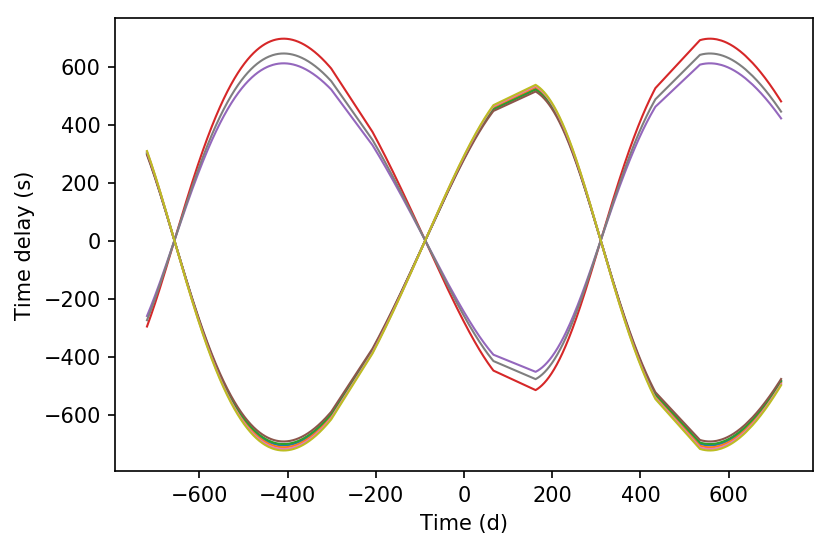

In [17]:
for i in range(len(nu_arr)):
    plt.plot(times, map_soln['tau'].T[i]*86400-np.mean(map_soln['tau'].T[i]), 
            lw=1)
plt.xlabel('Time (d)')
plt.ylabel('Time delay (s)')

In [19]:
lt = map_soln['lighttime']

if np.any(lt < 0) and np.any(lt > 0):
    print('This looks like a double pulsator system! Neat!')

This looks like a double pulsator system! Neat!


In [20]:
lt = map_soln['lighttime']

lt_ivar = np.arange(len(nu_arr)).astype(np.int32)

chi = lt * np.sqrt(lt_ivar)
mask_lower = chi < -1.0        
mask_upper = chi > 1.0

if np.any(mask_lower) and np.any(mask_upper):
    m1 = lt >= 0
    m2 = ~m1
    lt = np.array([
        np.sum(lt_ivar[m1]*lt[m1]) / np.sum(lt_ivar[m1]),
        np.sum(lt_ivar[m2]*lt[m2]) / np.sum(lt_ivar[m2]),
    ])
    inds = 1 - m1.astype(np.int32)
else:
    inds = np.zeros(len(lt), dtype=np.int32)
    lt = np.array([np.sum(lt_ivar*lt) / np.sum(lt_ivar)])
    
pinned_lt = lt
pinned_lt

array([ 580.3789844 , -640.52604162])

Now we get the frequencies where the lighttimes are positive and negative so we can remake the model

In [21]:
nu_arr_positive = nu_arr[np.where(inds==1)]
nu_arr_negative = nu_arr[np.where(inds==0)]

You can then remake the model with the positive and negative lighttimes etc. I haven't gotten around to doing this yet but you get the idea

<a id='TimeDelay'></a>
# 3. The TimeDelay module

Finally, the last thing I'd have you look at is this little module I developed for some collaborators in Austria. It doesn't forward model the lightcurve, rather it uses the old method of segmenting. If you want to run this you'll need to `python setup.py develop` https://github.com/danielhey/timedelay.git

100%|██████████| 64028/64028 [00:00<00:00, 749295.90it/s]


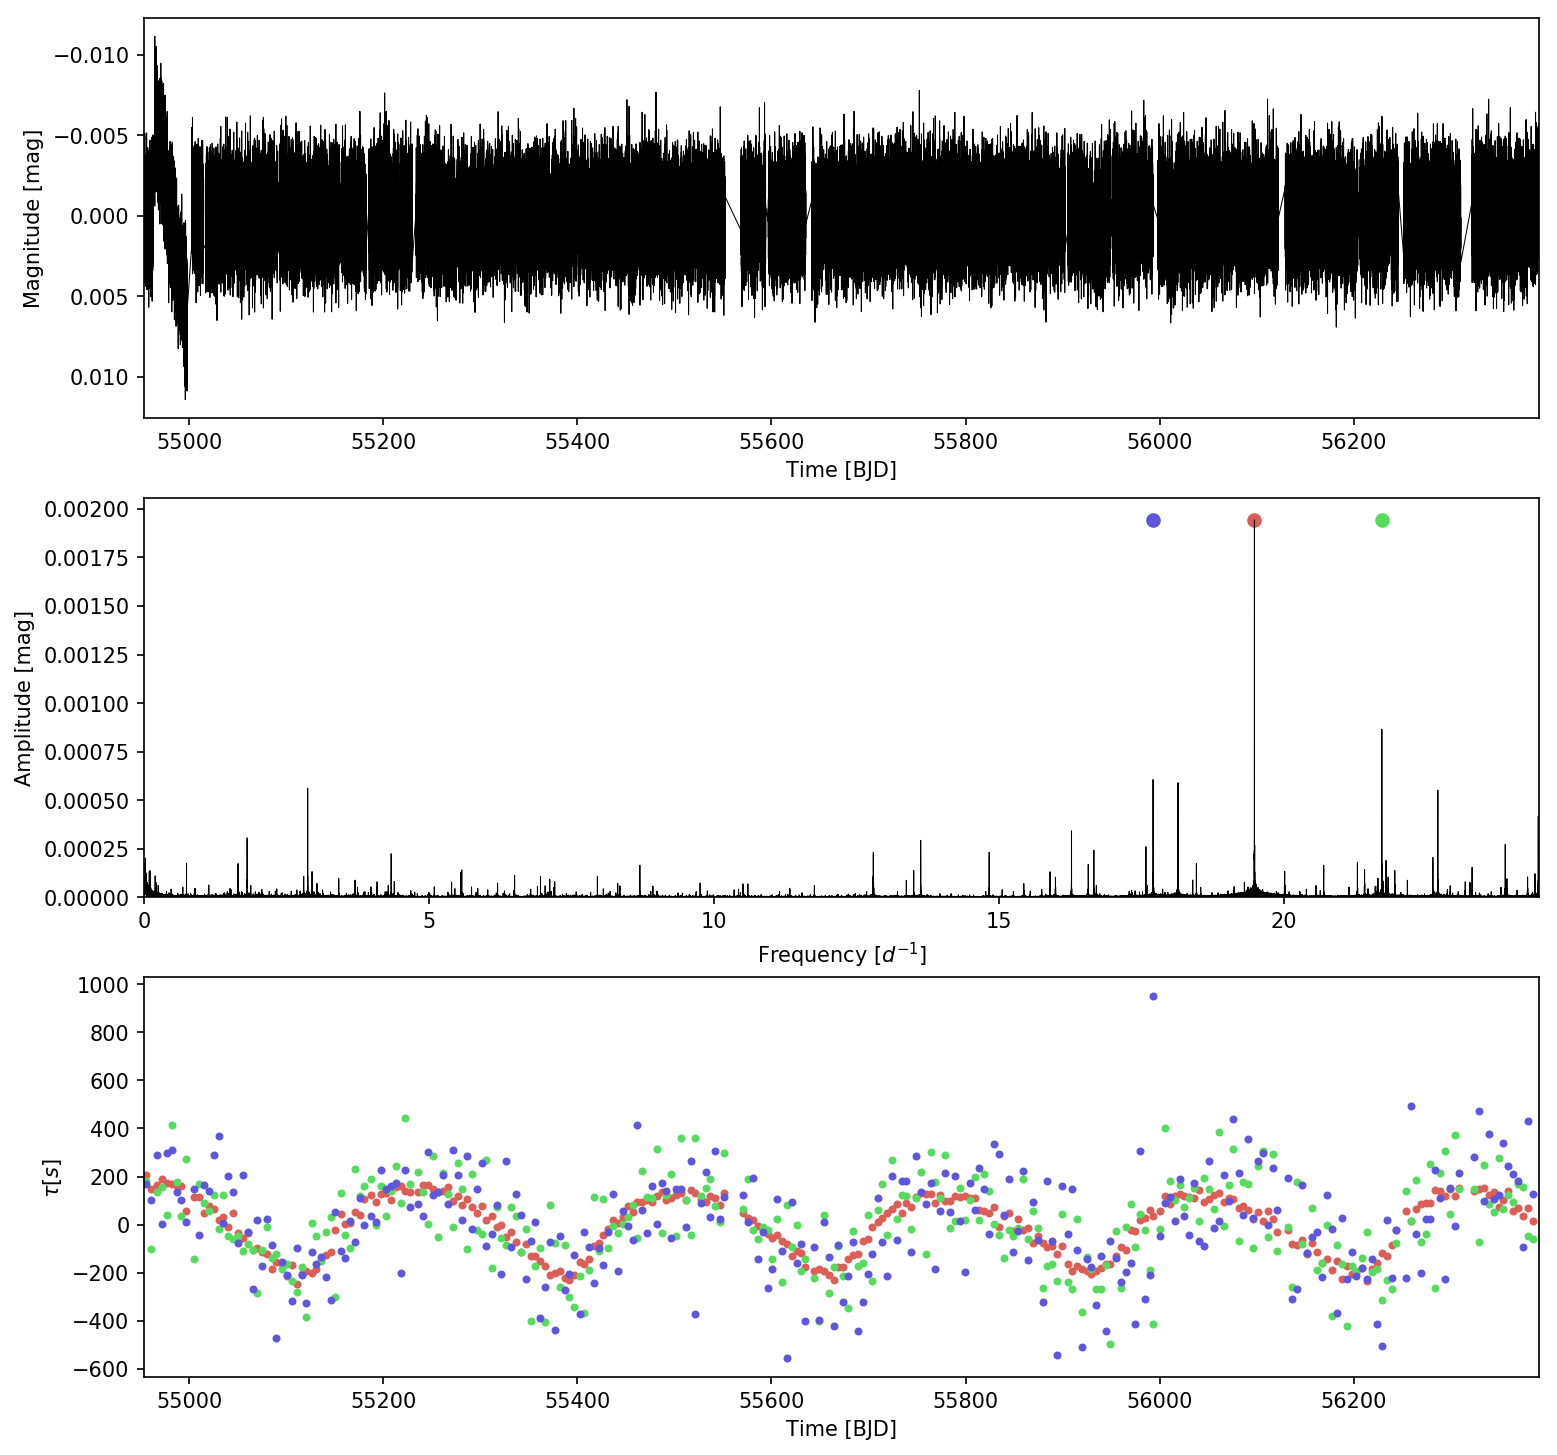

In [24]:
from timedelay import TimeDelay

kicid = 9651065
times, mags = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T

td = TimeDelay(times, mags, max_peaks=3)
td.first_look(segment_size=5)

I've been looking into ways to mitigate the undersampling near periastron when segmenting the lightcurve. It's not the prettiest code out there (i'm looking at you Dan), but I basically slide a Gaussian window across the lightcurve and calculate the time delay within each window - pretty much a wavelet. While this gives the illusion of solving the periastron sampling problem, I'm not really sure if it actually does. It definitely helps out with undersampling, but surrounding values near periastron will also be used to calculate the time delay signal

100%|██████████| 500/500 [00:05<00:00, 93.05it/s]


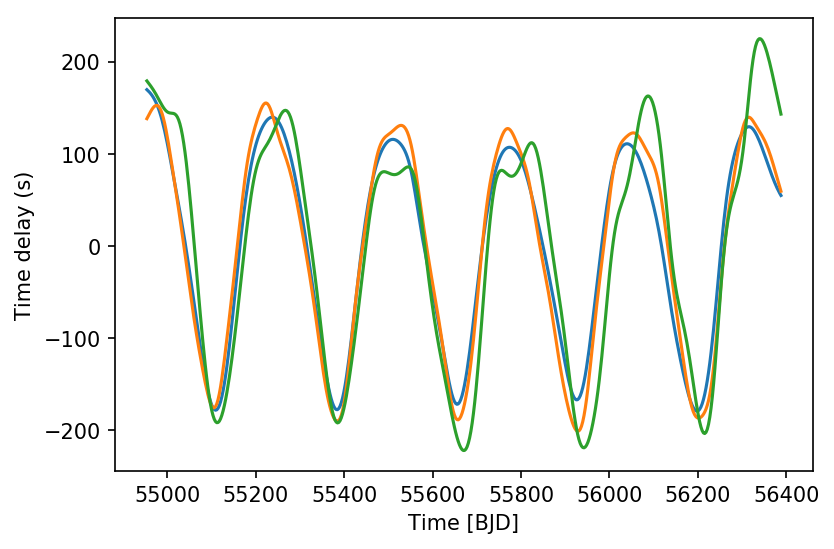

In [25]:
td.plot_wavelet_td(windows=500,gwidth=20)

<a id='td_model'></a>
## 3.1. Binary model

While we're on the topic of my TimeDelay module, I hope to put it into the Maelstrom package as a kind of quick-look tool for extracting and modelling time delays on the fly. Maelstrom is fantastic, but also super slow so it'd be nice to have some quick code to test. I've built a super basic binary model into the TimeDelay package **which fits the time delays themselves instead of forward modelling of the whole lightcurve**

In [26]:
tdm = td.to_model()

This model uses PyMC3 for sampling (we'll get to that later), and initialises the period based on the amplitude spectrum of the time delay curve, which is something Maelstrom should do at some point. It also uses Dan's Exoplanet package (hah) for the insane Kepler solver. I can't believe how fast that is

In [27]:
tdm.period

period

In [28]:
tdm.sample(draws=1000, tune=1000, chains=4, cores=4)

logp = -6.3509e+06, ||grad|| = 5,866.8: 100%|██████████| 75/75 [00:00<00:00, 1167.20it/s]     
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lighttime, eccen, varpi, tref, period]
Sampling 4 chains: 100%|██████████| 8000/8000 [07:27<00:00,  5.46draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,273.108962,0.007974,0.000159,273.093161,273.123835,2217.164855,1.000008
lighttime__0,-179.453597,0.088946,0.001593,-179.626287,-179.277218,2456.816810,1.000586
lighttime__1,-188.343340,0.084818,0.001598,-188.501450,-188.177983,2391.790322,1.000649
lighttime__2,-192.931396,0.087741,0.001563,-193.098366,-192.755174,2550.275117,0.999706
tref,-584.326651,1.641315,0.032656,-587.368217,-581.066082,2222.719166,1.000005
varpi,24.131525,0.001334,0.000026,24.128862,24.134116,2959.894667,0.999836
eccen,0.422728,0.000567,0.000012,0.421657,0.423851,2051.434859,1.000907


Once the sampler is done it'll return the optimised values of the model. The way I've defined the model is that for each frequency there is an independent lighttime. This isn't so great for PB1 stars (where only one star is pulsating in the binary), but works very well for PB2 systems. When I get around to it, I'll use exoplanet.optimize to pin the lighttimes and then remake the model using only 1 (PB1) or 2 (PB2) lighttimes. You can see how each lighttime is slightly different even though they all belong to the same star

/Users/danielhey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/danielhey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/danielhey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/danielhey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. U

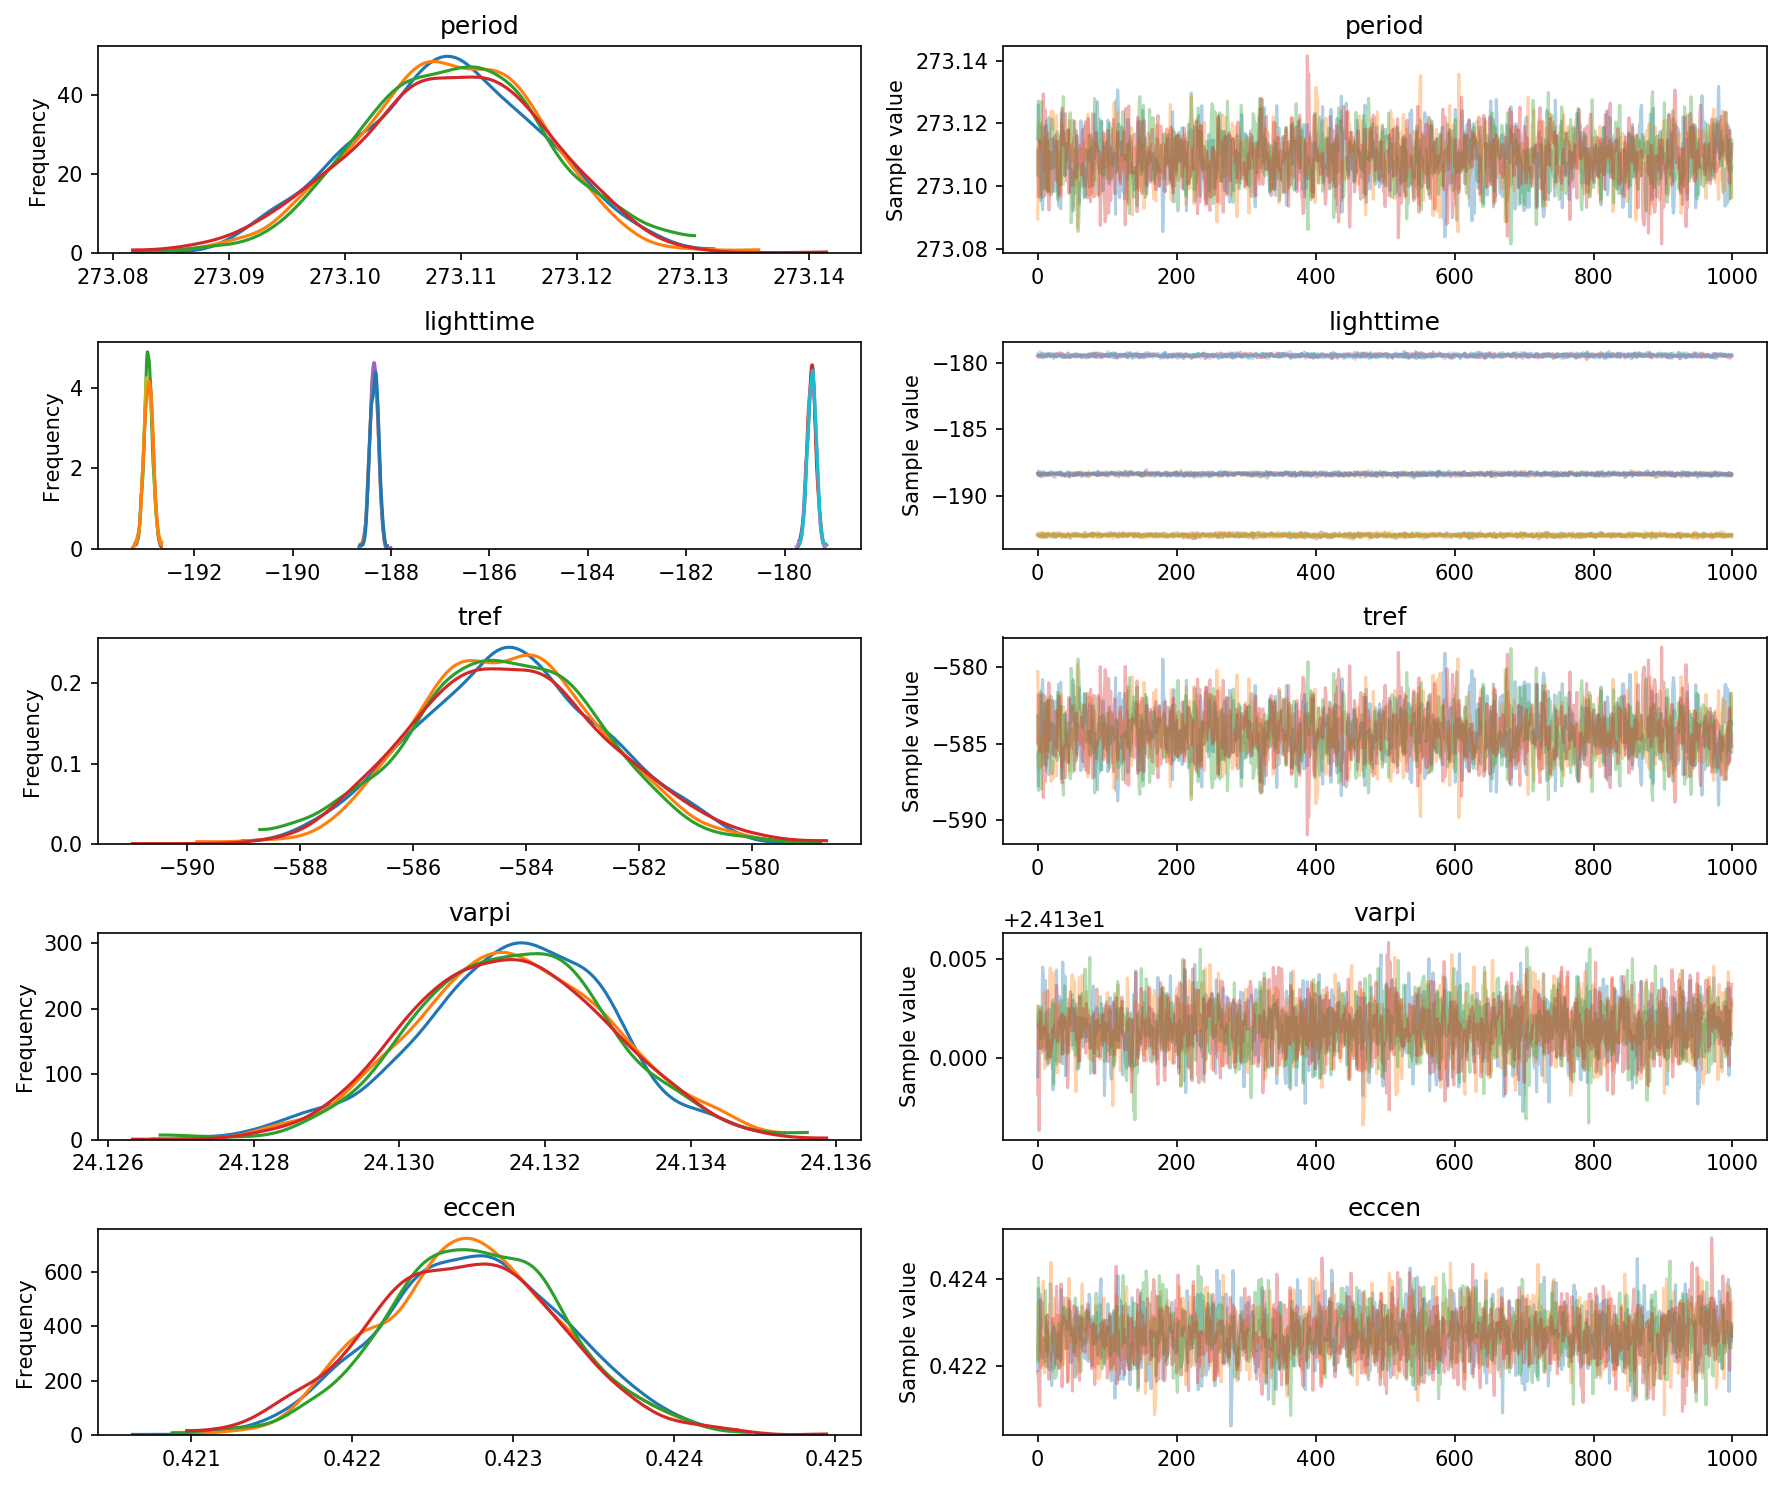

In [29]:
tdm.trace_plot()

Dashy cray